In [112]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



In [40]:
def evaluateBinaryClassification(y_pred, y) :
    contigency = pd.crosstab(y, y_pred)
    TP = contigency[1][1]
    TN = contigency[0][0]
    FP = contigency[0][1]
    FN = contigency[1][0]
    n = len(y)
    Accuracy = (TP+TN)/n
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    Fscore = 2*Recall*Precision/(Recall+Precision)
    
    return Accuracy, Recall, Precision, Fscore

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 12)
(889, 9)


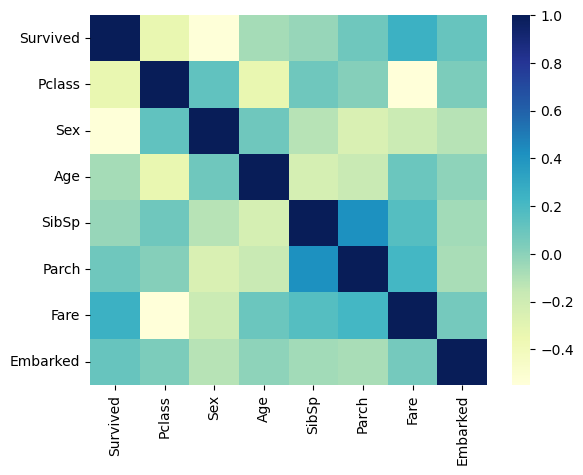

In [134]:
train_data_path = 'train.csv'
test_data_path = 'test.csv'

data = pd.read_csv(train_data_path)

# Analyzing the data
columns = data.columns
print(columns)
print(data.shape)


# Here I choosed to replace empty age with the mean
mean_age = data["Age"].mean()
median_age = data.Age.median()
data["Age"].fillna(median_age, inplace=True)

# Remove Cabin, Name and Ticket columns
data.drop(["Name","Cabin", "Ticket"], axis=1, inplace=True)
data.dropna(inplace=True)
print(data.shape)

# Coding the Sex and Embarked, respectively to 0-1 and 0-2
data["Sex"] = data["Sex"].replace({"male" : 1, "female" : 0})
data["Embarked"] = data["Embarked"].replace({"S" : 0, "C" : 1, "Q" : 2})
data.set_index("PassengerId", inplace=True)


# See the correclation between variables 

sns.heatmap(data.corr(), cmap = "YlGnBu")

# Prepare the data
X = data.iloc[:, 1:]
y = data.iloc[: , 0]

# Standarize the data
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)

# Split into validation and training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a Table to compare method
Methods = ['DTR', 'DTC', 'NB']
Metrics = ['Accuracy', 'Recall', 'Precision', 'Fscore']
compare_df = pd.DataFrame(index = Methods, columns=Metrics)



## Decision Tree Regressor


In [42]:
# Specify Model
DTR = DecisionTreeRegressor(max_depth = 10,  min_samples_leaf = 5, random_state=1)
# Fit Model

print(X_train.head())
DTR.fit(X_train, y_train)

# Make validation predictions

y_pred_DTR = DTR.predict(X_val)
threshold = 0.5
y_pred_DTR = (y_pred_DTR > threshold).astype(int)

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_DTR)
print("The propotion of false predictions:" , val_MAE)

Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_DTR, y_val)

print('Accuracy={}'.format(Accuracy))
print('Recall={}'.format(Recall))
print('Precision={}'.format(Precision))
print('Fscore={}'.format(Fscore))

compare_df.loc['DTR'] = evaluateBinaryClassification(y_pred_DTR, y_val)

pd.crosstab(y_val, y_pred_DTR)


       Pclass       Sex       Age     SibSp     Parch      Fare  Embarked
120  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.484133 -0.569684
686  0.825209  0.735342 -0.794841 -0.475199 -0.474326 -0.441435 -0.569684
789  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.490173  2.575963
835  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.484133 -0.569684
658 -1.572211  0.735342  2.210331 -0.475199  2.006119  1.634368  1.003139
The propotion of false predictions: 0.15730337078651685
Accuracy=0.8426966292134831
Recall=0.8461538461538461
Precision=0.7534246575342466
Fscore=0.7971014492753623


col_0,0,1
Survived,,
0,95,10
1,18,55


## Decision Tree Classifier



In [12]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

y_pred_DTC = DTC.predict(X_val)

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_DTC)
print("The propotion of false predictions:" , val_MAE)


Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_DTC, y_val)

print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))


pd.crosstab(y_val, y_pred_DTC)


The propotion of false predictions: 0.2247191011235955
Accuracy = 0.7752808988764045
Recall = 0.7391304347826086
Precision = 0.6986301369863014
Fscore = 0.7183098591549297


col_0,0,1
Survived,,
0,87,18
1,22,51


Tuning the DT Classifier

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion' : ['gini', 'entropy'],
    
    'splitter'   : ['best', 'random'],
    'max_depth'  : [5, 10, 15, 20],
    'min_samples_split' : [5, 10, 15, 20, 30],
    'min_impurity_decrease' : [0, 0.0005, 0.001, 0.005, 0.01],
}


gridSearch = GridSearchCV(DecisionTreeClassifier(),
                          param_grid, 
                          cv = 5, 
                          scoring='accuracy' )

gridSearch.fit(X_train, y_train)

print('score :', gridSearch.best_score_)
print('paramaters : ' , gridSearch.best_params_)


score : 0.82414064808431
paramaters :  {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 5, 'splitter': 'random'}


In [44]:

param_grid = {
    'criterion' : ['entropy'],
    'splitter'   : [ 'random'],
    'max_depth'  : [7, 8, 9, 10, 11, 12, 13, 14],
    'min_samples_split' : [3,2,4,5,6, 10, 11, 12],
    'min_impurity_decrease' : [0.0001, 0.005, 0.01] 
}


gridSearch = GridSearchCV(DecisionTreeClassifier(),
                          param_grid, 
                          cv = 5, 
                          scoring='accuracy' )

gridSearch.fit(X_train, y_train)

print('score :', gridSearch.best_score_)
print('paramaters : ' , gridSearch.best_params_)


score : 0.8269378508815131
paramaters :  {'criterion': 'entropy', 'max_depth': 14, 'min_impurity_decrease': 0.005, 'min_samples_split': 4, 'splitter': 'random'}


In [104]:
best_criterion = 'entropy'
best_max_depth = 14
best_min_impurity_decrease = 0.005
best_min_samples_split =4
best_splitter = 'random'

DTC = DecisionTreeClassifier(criterion = best_criterion, 
                             max_depth = best_max_depth,
                             min_impurity_decrease = best_min_impurity_decrease,
                             min_samples_split = best_min_samples_split,
                            splitter = best_splitter)
DTC.fit(X_train, y_train)

y_pred_DTC = DTC.predict(X_val)

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_DTC)
print("The propotion of false predictions:" , val_MAE)


Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_DTC, y_val)

print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))

compare_df.loc['DTC'] = evaluateBinaryClassification(y_pred_DTC, y_val)


pd.crosstab(y_val, y_pred_DTC)



The propotion of false predictions: 0.16853932584269662
Accuracy = 0.8314606741573034
Recall = 0.9387755102040817
Precision = 0.6301369863013698
Fscore = 0.7540983606557377


col_0,0,1
Survived,,
0,102,3
1,27,46


## K Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_knn)
print("The propotion of false predictions:" , val_MAE)
Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_knn, y_val)
print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))

compare_df.loc['NB'] = evaluateBinaryClassification(y_pred_knn, y_val)


pd.crosstab(y_val, y_pred_knn)


The propotion of false predictions: 0.19662921348314608
Accuracy = 0.8033707865168539
Recall = 0.8166666666666667
Precision = 0.6712328767123288
Fscore = 0.7368421052631579


col_0,0,1
Survived,,
0,94,11
1,24,49


Tuning K nearest neighbors


In [47]:
param_grid_knn = { 'n_neighbors' : [1, 2, 3, 5, 8, 10],
                    'weights'    : ['uniform', 'distance'],
                }

gridSearch_knn = GridSearchCV(KNeighborsClassifier(),
                              param_grid= param_grid_knn,
                              cv = 5,
                              scoring='accuracy')

gridSearch_knn.fit(X_train, y_train)

print('score :', gridSearch_knn.best_score_)
print('paramaters : ' , gridSearch_knn.best_params_)

score : 0.8087067861715749
paramaters :  {'n_neighbors': 10, 'weights': 'uniform'}


In [48]:
param_grid_knn = { 'n_neighbors' : [8, 10, 11, 12, 13, 14 , 20],
                    'weights'    : ['uniform'],
                }

gridSearch_knn = GridSearchCV(KNeighborsClassifier(),
                              param_grid= param_grid_knn,
                              cv = 5,
                              scoring='accuracy')

gridSearch_knn.fit(X_train, y_train)

print('score :', gridSearch_knn.best_score_)
print('paramaters : ' , gridSearch_knn.best_params_)

score : 0.8087067861715749
paramaters :  {'n_neighbors': 10, 'weights': 'uniform'}


In [110]:
knn = KNeighborsClassifier(n_neighbors=10, weights= 'uniform').fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_knn)
print("The propotion of false predictions:" , val_MAE)
Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_knn, y_val)
print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))

compare_df.loc['KNN'] = evaluateBinaryClassification(y_pred_knn, y_val)


pd.crosstab(y_val, y_pred_knn)

       Pclass       Sex       Age     SibSp     Parch      Fare  Embarked
120  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.484133 -0.569684
686  0.825209  0.735342 -0.794841 -0.475199 -0.474326 -0.441435 -0.569684
789  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.490173  2.575963
835  0.825209  0.735342 -0.101340 -0.475199 -0.474326 -0.484133 -0.569684
658 -1.572211  0.735342  2.210331 -0.475199  2.006119  1.634368  1.003139
..        ...       ...       ...       ...       ...       ...       ...
715 -1.572211 -1.359911  0.669217 -0.475199 -0.474326  3.934570  1.003139
767  0.825209  0.735342 -0.101340  0.431350 -0.474326 -0.159991  2.575963
72   0.825209  0.735342 -0.255451  0.431350 -0.474326 -0.355197  1.003139
235 -0.373501  0.735342  1.131551  0.431350 -0.474326 -0.122745 -0.569684
37   0.825209  0.735342 -0.640730 -0.475199 -0.474326 -0.484133 -0.569684

[711 rows x 7 columns]
The propotion of false predictions: 0.1853932584269663
Accuracy = 0.8146067415730337
Rec

col_0,0,1
Survived,,
0,97,8
1,25,48


## Naive Bayesian Classification

In [50]:
from sklearn.naive_bayes import MultinomialNB

X = data.iloc[:, 1:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Making prediction
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_val)


# Performance
val_MAE = mean_absolute_error(y_val, y_pred_nb)
print("The propotion of false predictions:" , val_MAE)
Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_nb, y_val)
print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))

compare_df.loc['NB'] = evaluateBinaryClassification(y_pred_nb, y_val)


pd.crosstab(y_val, y_pred_nb)



The propotion of false predictions: 0.34831460674157305
Accuracy = 0.651685393258427
Recall = 0.5964912280701754
Precision = 0.4657534246575342
Fscore = 0.5230769230769231


col_0,0,1
Survived,,
0,82,23
1,39,34


Tuning our Naive Bayesien 

In [251]:
y_prob = nb.predict_proba(X_val)   

summary_df = pd.concat([pd.DataFrame({'actual' : y_val, 'pred' : y_pred_nb}),
                        pd.DataFrame(y_prob, index = y_val.index, columns = ['No_prob', 'Yes_prob'])], axis = 1)

summary_df.sort_values('No_prob', ascending=False)

Thresholds = np.linspace(0.95, 1, 10)
for tr in Thresholds :
    No_number = np.sum(summary_df.No_prob > tr)
    print("Number of No for threshold {} is {}".format(tr, No_number))
    
best_tr = 0.8

Number of No for threshold 0.95 is 110
Number of No for threshold 0.9555555555555555 is 108
Number of No for threshold 0.961111111111111 is 108
Number of No for threshold 0.9666666666666667 is 108
Number of No for threshold 0.9722222222222222 is 107
Number of No for threshold 0.9777777777777777 is 107
Number of No for threshold 0.9833333333333333 is 107
Number of No for threshold 0.9888888888888889 is 106
Number of No for threshold 0.9944444444444445 is 97
Number of No for threshold 1.0 is 0


In [265]:
y_pred_nb = pd.Series(summary_df.No_prob > 0.5).replace({True : 0, False : 1})

# Performance
val_MAE = mean_absolute_error(y_val, y_pred_nb)
print("The propotion of false predictions:" , val_MAE)
Accuracy, Recall, Precision, Fscore = evaluateBinaryClassification(y_pred_nb, y_val)
print('Accuracy = {}'.format(Accuracy))
print('Recall = {}'.format(Recall))
print('Precision = {}'.format(Precision))
print('Fscore = {}'.format(Fscore))
pd.crosstab(y_val, y_pred_nb)

The propotion of false predictions: 0.34831460674157305
Accuracy = 0.651685393258427
Recall = 0.5964912280701754
Precision = 0.4657534246575342
Fscore = 0.5230769230769231


No_prob,0,1
Survived,,
0,82,23
1,39,34


In [111]:
compare_df

,Accuracy,Recall,Precision,Fscore
DTR,NaN,NaN,NaN,NaN
DTC,0.831461,0.938776,0.630137,0.754098
NB,NaN,NaN,NaN,NaN
KNN,0.814607,0.857143,0.657534,0.744186


In [133]:
# Here I choosed to replace empty age with the mean
# mean_age = test["Age"].mean()
# median_age = test.Age.median()

test = pd.read_csv(test_data_path)
test["Age"].fillna(median_age, inplace=True)
print(test.shape)



# Remove Cabin, Name and Ticket columns
test.drop(["Name","Cabin", "Ticket"], axis=1, inplace=True)
test.set_index('PassengerId', inplace=True)
median_fare = test.Fare.median()
test.Fare.fillna(median_fare, inplace=True)


# Coding the Sex and Embarked, respectively to 0-1 and 0-2
test["Sex"] = test["Sex"].replace({"male" : 1, "female" : 0})
test["Embarked"] = test["Embarked"].replace({"S" : 0, "C" : 1, "Q" : 2})


# Prepare data
X_test = test

# Standarize the data
scaler = StandardScaler()
scaler.fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


# Prediction with DTR 
y_pred_DR = DTR.predict(X_test)
threshold = 0.5
y_pred_DR = (y_pred_DR > threshold).astype(int)
y_pred_DR = pd.Series(y_pred_DR, index=test.index, name= 'Survived')
y_pred_DR.to_csv('UsingDTR_v1.csv')

# Prediction with DTC 

y_pred_DC = DTC.predict(X_test)
y_pred_DC = pd.Series(y_pred_DC, index=test.index, name= 'Survived')
y_pred_DC.to_csv('UsingDTC_v1.csv')

# Prediction with KNN

y_pred_KNN = knn.predict(X_test)
y_pred_KNN = pd.Series(y_pred_KNN, index=test.index, name= 'Survived')
y_pred_KNN.to_csv('UsingKNN_v1.csv')


(418, 11)
